## Imports

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from data_preprocessor import DataPreprocessor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

## Data Cleaning and EDA

In [116]:
logger_2024 = pd.read_csv('trip_logger_2024.csv')
logger_2025 = pd.read_csv('trip_logger_2025.csv')

In [117]:
logger_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5677 entries, 0 to 5676
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TRIP DATE                 5670 non-null   float64
 1   Include                   1800 non-null   float64
 2   NOTES                     5582 non-null   object 
 3   CLIENT                    5600 non-null   object 
 4   PICK UP POINT             5602 non-null   object 
 5   DELIVERY AREA             5604 non-null   object 
 6   Route                     5604 non-null   object 
 7   WEIGHT (For Billing)      5613 non-null   object 
 8   CARGO TYPE                5614 non-null   object 
 9   REF#                      5600 non-null   object 
 10  Trip Report               5610 non-null   object 
 11  DM Recorded               5556 non-null   object 
 12  Complete Docs?            5583 non-null   object 
 13  Outlet Count              1250 non-null   object 
 14  BILLING 

In [118]:
logger_2024.head()

,TRIP DATE,Include,NOTES,CLIENT,PICK UP POINT,DELIVERY AREA,Route,WEIGHT (For Billing),CARGO TYPE,REF#,...,TIME,LTRS,PER LITER,AMOUNT,FUEL / RATE,SALARIES,TOTAL FUEL,Other Expenses,GI,NET / RATE 45^
0,45292.0,NaN,-,-,-,-,-,-,-,-,...,-,-,0.0,0,0,0.0,0,0,0.0,0.0
1,45292.0,NaN,-,-,-,-,-,-,-,-,...,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0.0,0.0
2,45292.0,NaN,-,-,-,-,-,-,-,-,...,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0.0,0.0
3,45292.0,NaN,NaN,-,-,-,-,-,-,-,...,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0.0,0.0
4,45292.0,NaN,-,-,-,-,-,-,-,-,...,NaN,NaN,NaN,NaN,NaN,0.0,0,0,0.0,0.0


In [119]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """ Cleans up raw dataset to obtain interesting features for machine learning. """

    df = df.copy()
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    df = df[df['include']==1]
    df['trip_date'] = pd.to_datetime(df['trip_date'], unit='D', origin='1899-12-30')
    df = df.rename(columns={'weight_(for_billing)': 'cargo_weight', 'rate_vat-ex': 'trucking_rate', 'ltrs': 'fuel_liters', 'total_fuel': 'fuel_cost'})

    selected_cols = ['trip_date', 'client', 'pick_up_point', 'delivery_area', 'route', 'cargo_weight', 'cargo_type', 'outlet_count', 'trucking_rate', 'fuel_liters', 'fuel_cost']
    
    df = df.dropna(subset=['fuel_liters', 'fuel_cost'])
    
    df['cargo_weight'] = df['cargo_weight'].str.lower()
    df = df[df['cargo_weight'].isin(['4t', '2t'])]

    # convert to numeric
    df['trucking_rate'] = pd.to_numeric(df['trucking_rate'].str.strip(), errors='coerce')
    df['outlet_count'] = pd.to_numeric(df['outlet_count'], errors='coerce')
    df['fuel_liters'] = pd.to_numeric(df['fuel_liters'], errors='coerce')
    df['fuel_cost'] = pd.to_numeric(df['fuel_cost'], errors='coerce')

    # remove rows with fuel_liters > 1000
    df = df[df['fuel_liters']<1000]

    # set selected cols to lower case
    cols_to_lower = ['client', 'pick_up_point', 'delivery_area', 'route', 'cargo_type']
    df[cols_to_lower] = df[cols_to_lower].apply(lambda x: x.str.strip().str.lower())

    # count number of outlets based on route
    df['outlet_count'] = df.apply(lambda row: row['route'].count('-')+1 if pd.isna(row['outlet_count']) else row['outlet_count'], axis=1)
    df['delivery_area'] = df['delivery_area'].replace({'laguna (special)': 'laguna', 'gm': 'gma'})
    df = df[selected_cols]
    
    return df

In [120]:
# clean the input files and concatenate into one df
logger_2024_clean = clean_data(logger_2024)
logger_2025_clean = clean_data(logger_2025)
trips_df = pd.concat([logger_2024_clean, logger_2025_clean]).reset_index(drop=True)

# load the distances per delivery area and merge to the df
distances_df = pd.read_csv('distance_travelled.csv')
trips_df = trips_df.merge(distances_df, how='left', on='delivery_area')

# add new cols cargo
trips_df['cargo'] = trips_df['cargo_weight'] + "_" + trips_df['cargo_type']
trips_df['fuel_cost_60_per_L'] = trips_df['fuel_liters']*60

# create a mapping for the overall delivery areas
area_dict = {
    'gma': ['gma', 'gma-t3'],
    'north_luzon': ['bulacan', 'baguio', 'pampanga', 'subic-tarlac', 'camaya', 'dagupan', 'tarlac', 'pampanga-bulacan', 'baguio-tarlac', 'subic', 'tuguegarao', 'la union', 'ilocos', 'zambales', 'bataan', 'pangasinan', 'nueva ecija', 'nueva viscaya', 'ilocos sur', 'isabela', 'san fernando', 'subic-camaya', 'baguio-pampanga'],
    'south_luzon': ['batangas', 'cavite', 'laguna', 'naga', 'legaspi', 'lucena', 'mindoro', 'tagaytay', 'sta. rosa'],
    'visayas': ['cebu', 'iloilo', 'bacolod'],
    'mindanao': ['davao', 'cotabato']
}
city_to_area_map = {}

for larger_area, cities in area_dict.items():
    for city in cities:
        city_to_area_map[city] = larger_area

trips_df['grouped_areas'] = trips_df['delivery_area'].map(city_to_area_map)
trips_df['grouped_areas'] = trips_df['grouped_areas'].fillna(trips_df['delivery_area'])

# add distance travelled squared feature
trips_df['distance_travelled_squared'] = trips_df['distance_travelled']**2

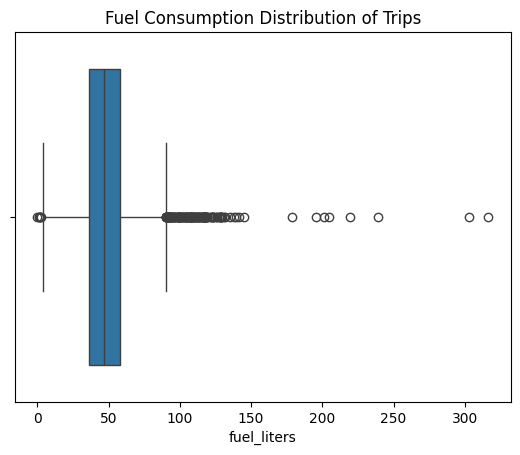

In [121]:
sns.boxplot(data=trips_df, x='fuel_liters')
plt.title('Fuel Consumption Distribution of Trips')
plt.show()

In [122]:
trips_df[trips_df['fuel_liters']<3]

,trip_date,client,pick_up_point,delivery_area,route,cargo_weight,cargo_type,outlet_count,trucking_rate,fuel_liters,fuel_cost,distance_travelled,cargo,fuel_cost_60_per_L,grouped_areas,distance_travelled_squared
558,2024-03-24,an,gma,laguna,wg-aw-comm-bin-nuv,2t,frozen,5.0,NaN,1.933333,2544.10,137,2t_frozen,116.000000,south_luzon,18769
741,2024-04-27,tlci,cavite,gma,tmp forbes-robinsons metro quirino,2t,dry,2.0,NaN,1.141667,1517.00,80,2t_dry,68.500000,gma,6400
1001,2024-06-22,tlci,cavite,gma,"no brand uptc (pick up sta rosa, not received ...",2t,dry,1.0,6400.0,2.193750,2922.30,80,2t_dry,131.625000,gma,6400
1427,2024-10-11,an,gma,gma,ew-cainta-cainta-sl,4t,dry,3.0,5750.0,1.263889,1520.57,80,4t_dry,75.833333,gma,6400
1808,2025-01-20,an,gma,bulacan,nlex-boc-dd-vertis-tri,4t,dry,4.0,7700.0,1.880556,2497.61,127,4t_dry,112.833333,north_luzon,16129
2519,2025-06-14,tlci event cindy,gma,cavite,"meat & brew silang, cavite",4t,dry,1.0,4543.0,0.000000,4626.67,120,4t_dry,0.000000,south_luzon,14400


In [123]:
## clean up incorrect fuel liters

trips_df_cleaned = trips_df.copy()
# get total fuel liters and total fuel cost of trips with >= 5 liters consumed
total_fuel_liters = trips_df_cleaned[trips_df_cleaned['fuel_liters']>=3]['fuel_liters'].sum()
total_fuel_cost = trips_df_cleaned[trips_df_cleaned['fuel_liters']>=3]['fuel_cost'].sum()

# take the average and compute the estimated fuel liters
average_cost_per_liter = total_fuel_cost / total_fuel_liters
estimated_fuel_liters = trips_df_cleaned.loc[trips_df_cleaned['fuel_liters']<3, 'fuel_cost'] / average_cost_per_liter

# replace values
trips_df_cleaned.loc[trips_df_cleaned['fuel_liters']<3, 'fuel_liters'] = estimated_fuel_liters

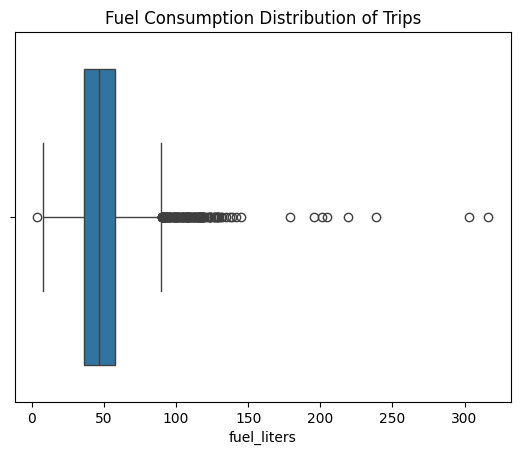

In [124]:
sns.boxplot(data=trips_df_cleaned, x='fuel_liters')
plt.title('Fuel Consumption Distribution of Trips')
plt.show()

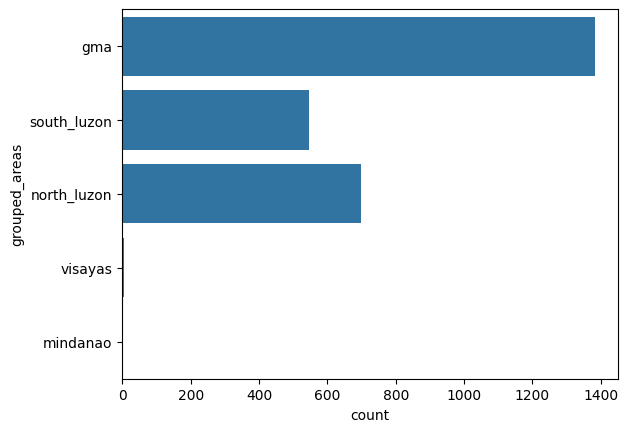

In [125]:
sns.countplot(trips_df_cleaned, y='grouped_areas')
plt.show()

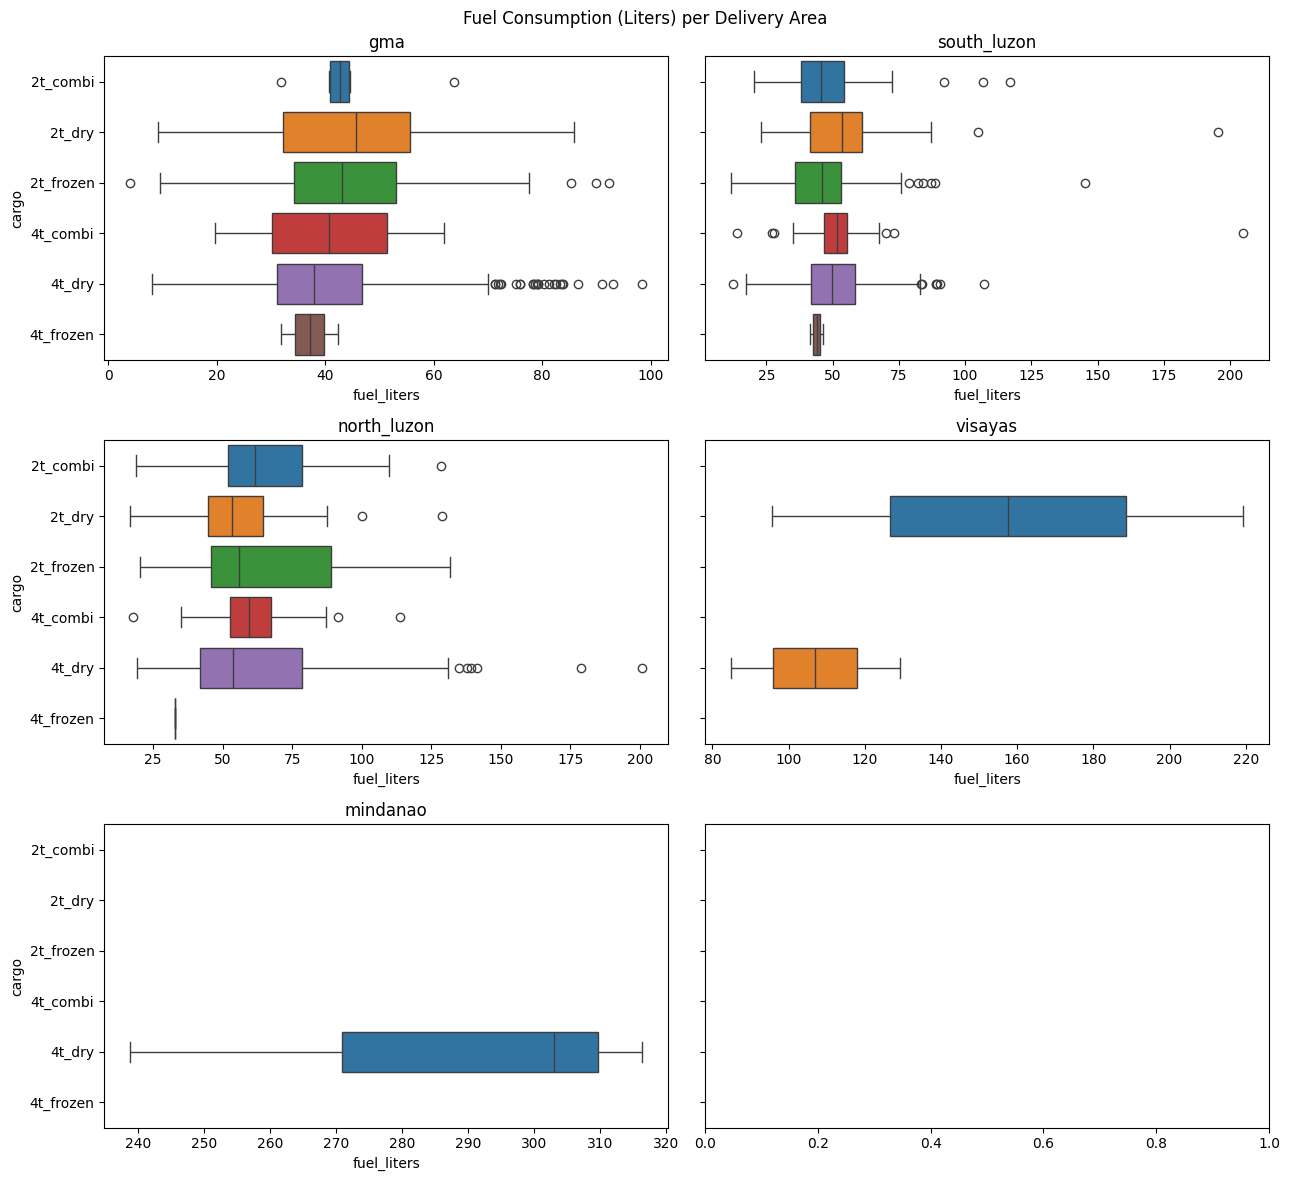

In [126]:
fig, ax = plt.subplots(3,2 , figsize=(13,12), sharey=True)
ax = ax.flatten()

area_list = trips_df_cleaned['grouped_areas'].unique()

sns.color_palette("hls", 12)
for i, delivery_area in enumerate(area_list):
    sns.boxplot(data=trips_df_cleaned[trips_df_cleaned['grouped_areas']==delivery_area].sort_values('cargo'), x='fuel_liters', y='cargo', hue='cargo', ax=ax[i])
    ax[i].set_title(delivery_area)
fig.suptitle('Fuel Consumption (Liters) per Delivery Area')
fig.tight_layout()
plt.show()

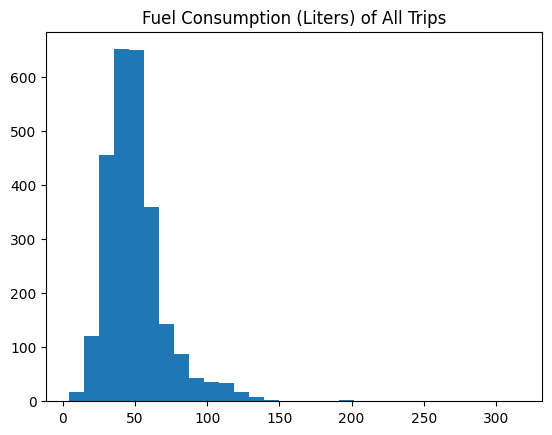

In [127]:
plt.hist(trips_df_cleaned['fuel_liters'], bins=30)
plt.title('Fuel Consumption (Liters) of All Trips')
plt.show()

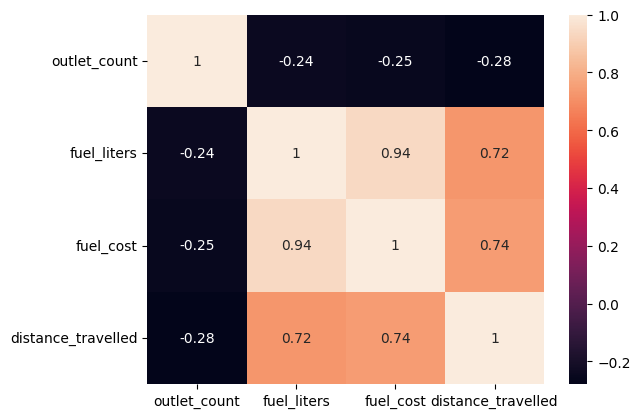

In [128]:
# check which numerical features might be useful for prediction
numerical_df = trips_df_cleaned[['outlet_count', 'fuel_liters', 'fuel_cost', 'distance_travelled']]
corr = numerical_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

## Prepare Data for Modelling

In [129]:
# select features
dataset = trips_df_cleaned.copy()
features = dataset[['grouped_areas', 'cargo_weight', 'cargo_type', 'distance_travelled']]
# features = dataset[['cargo_weight', 'cargo_type', 'distance_travelled']]
label = dataset['fuel_liters']

# split into training, val and test trying to ensure that areas are distributed accordingly
# X_train, X_temp, y_train, y_temp = train_test_split(features, label, test_size=0.2, random_state=40, stratify=features['grouped_areas'])
X_train, X_temp, y_train, y_temp = train_test_split(features, label, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=40)

In [130]:
# one hot encode categorical features and standardize numerical features
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
numerical_cols = features.select_dtypes(include=np.number).columns.tolist()

data_preprocessor = DataPreprocessor(categorical_cols, numerical_cols)

X_train_ohe, y_train_scaled = data_preprocessor.fit_transform(X_train, y_train)
X_val_ohe, y_val_scaled = data_preprocessor.transform(X_val, y_val)
X_test_ohe, y_test_scaled = data_preprocessor.transform(X_test, y_test)

## Model Training

#### Linear Regression

In [131]:
def compute_mse(y_train: np.array, y_train_pred: np.array):

    mse = mean_squared_error(y_train, y_train_pred)
    rmse = np.sqrt(mse)

    return mse, rmse

In [132]:
lr_model = LinearRegression().fit(X_train_ohe, y_train_scaled)

y_train_pred = lr_model.predict(X_train_ohe)
y_val_pred = lr_model.predict(X_val_ohe)

train_mse, train_rmse = compute_mse(y_train_scaled, y_train_pred)
train_r2 = r2_score(y_train_scaled, y_train_pred)
val_mse, val_rmse = compute_mse(y_val_scaled, y_val_pred)
val_r2 = r2_score(y_val_scaled, y_val_pred)

In [133]:
pd.DataFrame({'train': [train_mse, train_rmse, train_r2],
              'val': [val_mse, val_rmse, val_r2]})[['train', 'val']]

,train,val
0,0.465212,0.390538
1,0.682065,0.624930
2,0.534788,0.657170


#### Random Forest Regression

In [134]:
params = {'n_estimators': [100, 200, 300, 400, 500],
          'max_depth': [2, 3, 4, 5, 10, 20],
          'min_samples_leaf': [2, 3, 5, 10, 20]
}

In [135]:
n_iter = 100
cv_folds = 3

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                   param_grid=params, 
                                   scoring='neg_root_mean_squared_error',
                                   cv=cv_folds,
                                  return_train_score=True,
                                  verbose=1)
grid_search.fit(X_train_ohe, y_train_scaled)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [2, 3, ...], 'min_samples_leaf': [2, 3, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,400


In [136]:
print(grid_search.best_params_, grid_search.best_score_)

{'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 400} -0.6796622922150068


In [96]:
best_rf_model = grid_search.best_estimator_
y_train_preds = best_rf_model.predict(X_train_ohe)
y_val_preds = best_rf_model.predict(X_val_ohe)


rf_train_mse, rf_train_rmse = compute_mse(y_train_preds, y_train_scaled)
rf_val_mse, rf_val_rmse = compute_mse(y_val_preds, y_val_scaled)
print(f"Train MSE / RMSE: {rf_train_mse, rf_train_rmse}")
print(f"Val MSE / RMSE: {rf_val_mse, rf_val_rmse}")

Train MSE / RMSE: (0.4280767851332482, np.float64(0.6542757714704467))
Val MSE / RMSE: (0.49406596991039087, np.float64(0.7028982642675901))


#### Support Vector Regression

In [97]:
svr = SVR()
svr.fit(X_train_ohe, y_train_scaled)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [98]:
y_train_preds = svr.predict(X_train_ohe)
svr_train_mse, svr_train_rmse = compute_mse(y_train_preds, y_train_scaled)
svr_train_mse, svr_train_rmse

(0.4718906505712842, np.float64(0.6869429747593931))

In [99]:
svr_params = {'C': [0.1, 0.5, 1],
              'kernel': ['rbf', 'sigmoid'],
              'epsilon': [0.1, 0.5, 1],
              'gamma': ['scale', 'auto'],
             }

grid_search_svr = GridSearchCV(estimator=SVR(), 
                                   param_grid=svr_params, 
                                   scoring='neg_root_mean_squared_error',
                                   cv=cv_folds,
                                  return_train_score=True,
                                  verbose=1)
grid_search_svr.fit(X_train_ohe, y_train_scaled)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


,estimator,SVR()
,param_grid,"{'C': [0.1, 0.5, ...], 'epsilon': [0.1, 0.5, ...], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'sigmoid']}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,kernel,'rbf'


In [100]:
print(grid_search_svr.best_params_, grid_search_svr.best_score_)

{'C': 1, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'} -0.707601065400012


In [101]:
best_svr_model = grid_search_svr.best_estimator_

y_train_preds = best_svr_model.predict(X_train_ohe)
y_val_preds = best_svr_model.predict(X_val_ohe)

svr_train_mse, svr_train_rmse = compute_mse(y_train_preds, y_train_scaled)
svr_val_mse, svr_val_rmse = compute_mse(y_val_preds, y_val_scaled)

print(f"Train MSE / RMSE: {svr_train_mse, svr_train_rmse}")
print(f"Val MSE / RMSE: {svr_val_mse, svr_val_rmse}")

Train MSE / RMSE: (0.46736540466668597, np.float64(0.6836412836178678))
Val MSE / RMSE: (0.6178260566204284, np.float64(0.7860191197550022))


#### Neural Network

In [102]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size: int, output_size:int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.fc1(x))
        output = self.relu(self.fc2(output))
        output = self.fc3(output)

        return output

In [103]:
class TripsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        # self.X = torch.from_numpy(X.toarray()).float()
        self.y = torch.from_numpy(y).float().view(-1,1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [104]:
train_dataset = TripsDataset(X_train_ohe, y_train_scaled)
val_dataset = TripsDataset(X_val_ohe, y_val_scaled)
test_dataset = TripsDataset(X_test_ohe, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [105]:
def train_nn(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader):
    num_epochs = 151
    train_losses = []
    val_losses = []

    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0

        for X, y in train_loader:
            preds = model(X)

            loss = mse_loss(preds,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(np.sqrt(train_loss))

        model.eval()
        val_running_loss = 0.0
    
        with torch.no_grad():
            for X, y in val_loader:
                preds = model(X)
                loss = mse_loss(preds, y)
                val_running_loss += loss.item()
    
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(np.sqrt(val_loss))
    
        if epoch % 20 == 0: 
            print(f"Epoch {epoch}, Loss: {np.sqrt(train_loss): .4f}, Validation Loss: {np.sqrt(val_loss):.4f}")

    return model, train_losses, val_losses


In [106]:
model = SimpleMLP(input_size=X_train_ohe.shape[1], output_size=1)
nn_model, nn_train_losses, nn_val_losses = train_nn(model, train_loader, val_loader)

Epoch 0, Loss:  1.0173, Validation Loss: 1.0432
Epoch 20, Loss:  0.6687, Validation Loss: 0.6267
Epoch 40, Loss:  0.6654, Validation Loss: 0.6183
Epoch 60, Loss:  0.6664, Validation Loss: 0.6179
Epoch 80, Loss:  0.6633, Validation Loss: 0.6165
Epoch 100, Loss:  0.6620, Validation Loss: 0.6159
Epoch 120, Loss:  0.6618, Validation Loss: 0.6118
Epoch 140, Loss:  0.6610, Validation Loss: 0.6109


In [107]:
print(nn_train_losses[-1], nn_val_losses[-1])

0.659549296972938 0.6131957832171566


## Model Evaluation

In [108]:
pd.DataFrame({'train_mse': [train_mse, rf_train_mse, svr_train_mse, nn_train_losses[-1] ],
              'val_mse': [val_mse, rf_val_mse, svr_val_mse, nn_val_losses[-1] ]}, index=['linear_regression', 'random_forest', 'svr', 'neural_network'])

,train_mse,val_mse
linear_regression,0.465212,0.390538
random_forest,0.428077,0.494066
svr,0.467365,0.617826
neural_network,0.659549,0.613196


In [109]:
pd.DataFrame({'train_mse': [train_mse, rf_train_mse, svr_train_mse, nn_train_losses[-1] ],
              'val_mse': [val_mse, rf_val_mse, svr_val_mse, nn_val_losses[-1] ]}, index=['linear_regression', 'random_forest', 'svr', 'neural_network'])

,train_mse,val_mse
linear_regression,0.465212,0.390538
random_forest,0.428077,0.494066
svr,0.467365,0.617826
neural_network,0.659549,0.613196


In [110]:
# random forest will be selected since it gives the best result in terms of train and val mse
y_test_pred_rf = best_rf_model.predict(X_test_ohe)
rf_test_mse, rf_test_rmse = compute_mse(y_test_scaled, y_test_pred_rf)
print(f'Random Forest MSE / RMSE: {rf_test_mse, rf_test_rmse}')

Random Forest MSE / RMSE: (0.5784996599153822, np.float64(0.7605916512264529))


## Model Selection & Saving

In [112]:
model_assets_dir = 'model_deployment_assets'
os.makedirs(model_assets_dir, exist_ok=True)

# save data_preprocessor and model
joblib.dump(data_preprocessor, os.path.join(model_assets_dir, 'data_preprocessor.pkl'))
joblib.dump(best_rf_model, os.path.join(model_assets_dir, 'fuel_prediction_rf_model.pkl'))


['model_deployment_assets\\fuel_prediction_rf_model.pkl']

In [113]:
model_assets_dir = 'model_deployment_assets'
loaded_preprocessor = joblib.load(os.path.join(model_assets_dir, 'data_preprocessor.pkl'))
loaded_model = joblib.load(os.path.join(model_assets_dir, 'fuel_prediction_rf_model.pkl'))

In [114]:
sample_input = {'grouped_areas': ['gma', 'south_luzon', 'north_luzon', 'north_luzon', 'visayas'],
              'cargo_weight': ['2t', '2t', '4t', '2t', '2t'],
              'cargo_type': ['frozen', 'frozen', 'dry', 'combi', 'frozen'],
              'distance_travelled': [70, 352, 352, 352, 494]
             }
sample_X_ohe = loaded_preprocessor.transform(sample_input)
sample_pred = loaded_model.predict(sample_X_ohe).reshape(-1,1)
sample_pred_rescaled = loaded_preprocessor.get_target_scaler().inverse_transform(sample_pred)
sample_pred_rescaled

array([[43.69119578],
       [71.2759341 ],
       [74.54499288],
       [64.85887001],
       [97.18197923]])